In [3]:
import glob
import os
import random
from skimage import exposure
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# import keras library
import keras

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
D_PATH = './trainingData'

In [4]:
# Assemble training and test data from @TrainingData files
data_file = sorted(glob.glob(f'{D_PATH}/*.npy'))
training_dicts=[]
for file in data_file:
    training_files= np.load(file,allow_pickle=True)
    training_dicts.append(training_files[()])
images = []
targets = []
for dict_ in training_dicts:
    for j in range(len(dict_['target'])):
        if dict_['data'][j].shape == (21, 21):
            images.append(dict_['data'][j])
            targets.append(dict_['target'][j])
if len(images) == len(targets):
    X = np.array(images)
    X= X[:,:,:,np.newaxis]
    y = np.array(targets)
    print (f"The Dataset contains {len(X)} images")
else:
    print ("Images and Targets dont match, check the training data!")



The Dataset contains 1124 images


In [5]:
def plot_digits(sample, images_per_row=10, **options):
    size = sample[0].shape[0] # get the size of x,y dimensions
    images_per_row = min(len(sample), images_per_row)
    images=[]
    for image in sample:
        percentiles = np.percentile(image, (1, 99))
        scaled=exposure.rescale_intensity(image, in_range=tuple(percentiles))
        images.append(scaled)
    n_rows = (len(sample) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(sample)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'gray', **options)
    plt.axis("off")
# TODO: change Function to add targets to each image

Saving figure MI_gallery


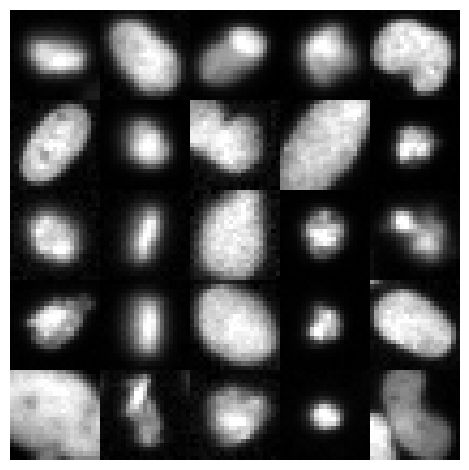

In [6]:
import pathlib
path = pathlib.Path.home() / 'Desktop'
def save_fig(fig_id, path=path, tight_layout=True, fig_extension="pdf", resolution=300):
    dest = path / f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(dest, format=fig_extension, dpi=resolution)

sample=random.sample(list(X), 25)
plot_digits(sample, images_per_row=5)
save_fig('MI_gallery')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape


(899, 21, 21, 1)

In [8]:
# # initialize standard scaler
# ss = StandardScaler()
#
# def scale_features(train_features, test_features):
#     for image in train_features:
#         # for each channel, apply standard scaler's fit_transform method
#         for channel in range(image.shape[2]):
#             image[:, :, channel] = ss.fit_transform(image[:, :, channel])
#     for image in test_features:
#         # for each channel, apply standard scaler's transform method
#         for channel in range(image.shape[2]):
#             image[:, :, channel] = ss.transform(image[:, :, channel])
#
#
# # apply scale_features to four sets of features
# scale_features(X_train, X_test)


In [9]:
# define model as Sequential
model = Sequential()
# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[21,21,1]))
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# add dropout to prevent over fitting
model.add(Dropout(0.25))
# add a thirs 2D convolutional layer with 128 filters
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
# add additional dropout to prevent overfitting
model.add(Dropout(0.5))
# prediction layers
model.add(Dense(1, activation='sigmoid', name='preds'))
# show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 19, 19, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 9, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                        

2023-11-27 16:50:18.643239: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-27 16:50:18.643265: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-27 16:50:18.643270: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-27 16:50:18.643360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-27 16:50:18.643387: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# Compile the model
model.compile(
    # set the loss as binary_crossentropy
    loss='binary_crossentropy',
    # set the optimizer as stochastic gradient descent
    optimizer='adam',
    # set the metric as accuracy
    metrics=['accuracy']
)

In [ ]:
# mock-train the model using the first ten observations of the train and test sets
history=model.fit(
    X_train,
    y_train,
    epochs=20,
    verbose=1,
    validation_split=0.2)

Epoch 1/20


In [1]:
model.evaluate(X_test,y_test)


NameError: name 'model' is not defined

In [2]:
y_proba=model.predict(X_test)

print("First five probabilities:")
print(y_proba[:10])
print("")

# predicted classes for x_eval
y_pred= np.round(y_proba).astype('int')

print("First five class predictions:")
print(y_pred[:10])
print("")

NameError: name 'model' is not defined

In [3]:
for i in range (10):
    plt.imshow(X_test[i], cmap='gray')
    plt.show(block=False)

NameError: name 'plt' is not defined

In [4]:
len(X_test)


NameError: name 'X_test' is not defined

In [5]:
# Extract the history from the training object
training = history.history

# Plot the training loss
plt.plot(training['accuracy'])
# Plot the validation loss
plt.plot(training['val_accuracy'])
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN model training')
save_fig('training_data')
# Show the figure
plt.show()

NameError: name 'history' is not defined

In [6]:
model.save(os.path.join(D_PATH,'MI_CNN_model01.h5'))

NameError: name 'model' is not defined

In [7]:
model1=keras.models.load_model(os.path.join(D_PATH,'MI_CNN_model01.h5'))

NameError: name 'keras' is not defined

In [8]:
model1.evaluate(X_test,y_test)

NameError: name 'model1' is not defined

In [9]:
X_test[1].shape

NameError: name 'X_test' is not defined